In [ ]:
'''
Scenario:
Imagine you are building an AI-powered workplace assistant that helps employees with different tasks, such as:


Answering General Knowledge Questions (Knowledge Agent)
Executing Python Code (Code Execution Agent)
Extracting Data from Text (Data Extraction Agent)
Since employees might ask a variety of questions, your system should intelligently route each request to the appropriate agent using LangGraph.

Example Inputs & Expected Agent Routing:
User Request	Expected Agent
"Summarize this document: [text]"	Summarization Agent
"Who was the first person to walk on the moon?"	Knowledge Agent
"Run this Python code: print(2+2)"	Code Execution Agent
"Extract all email addresses from this text: [text]"	Data Extraction Agent
'''

In [ ]:
#here lets create different agent for it
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict,Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage,HumanMessage
from IPython.display import Image, display


llm=ChatOpenAI(model="gpt-4o")

class router(BaseModel):
      step:Literal["general-knowledge","summerizer","extractor"]=Field(None,description="next step in routing") 


llm_with_router=llm.with_structured_output(router)



class State(TypedDict):
      input:str
      decision:str
      output:str
      

def llm_call_router(state:State):
     response=llm_with_router.invoke(
         [
             SystemMessage(content="route the user request to general-knowledge,summerizer or extractor ")
             ,HumanMessage(content=state["input"])
         ]
         
         
     )   
     return {"decision":response.step}
    
    
def route_decision(state:State):
    if state["decision"]=="general-knowledge":
        return "run_gk"
    
    elif state["decision"]=="summerizer":
        return "run_summerizer"
    
    elif state["decision"]=="extractor":
        return "run_extractor"
    
    
def run_gk(state:State):
    result=llm.invoke(state["input"])
    return {"output":result.content}

def run_summarizer(state:State):
    result=llm.invoke(state["input"])
    return {"output":result.content}
    

def run_extractor(state:State):
    result=llm.invoke(state["input"])
    return {"output":result.content}

        

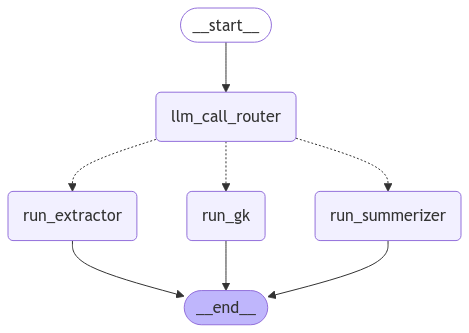

In [ ]:
builder=StateGraph(State)
builder.add_node("run_gk",run_gk)
builder.add_node("run_summerizer",run_summarizer)
builder.add_node("run_extractor",run_extractor)
builder.add_node("llm_call_router",llm_call_router)

builder.add_edge(START,"llm_call_router")
builder.add_conditional_edges("llm_call_router",route_decision,{"run_gk":"run_gk","run_summerizer":"run_summerizer","run_extractor":"run_extractor"})
builder.add_edge("run_gk",END)
builder.add_edge("run_summerizer",END)
builder.add_edge("run_extractor",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



    

In [19]:
graph.invoke({"input":"execute the python code  a = \"Hello, World! b = a.split(\",\") print(b)   "})




{'input': 'execute the python code  a = "Hello, World! b = a.split(",") print(b)   ',
 'decision': 'general-knowledge',
 'output': 'It looks like there\'s a small syntax error in the code you provided. The string assignment is missing a closing quote. Here\'s the corrected version of the code:\n\n```python\na = "Hello, World!"\nb = a.split(",")\nprint(b)\n```\n\nWhen you execute this code, it will split the string `a` at the comma, resulting in a list of two elements. The output will be:\n\n```\n[\'Hello\', \' World!\']\n```'}